What this notebook does:

LDA models with varying numbers of topics are fit to the collection of coffeeshop reviews, where each review is represented by only its lemmatized nouns + verbs. The lemmatized reviews are found in './ProcessedData/lemmatizedreviews.csv'

Interpretation of topics of the fitted models, based on top words was difficult. I decided not to move forward with using lda topics defined by nouns + verbs.

In [1]:
#Step one directory up to access the yelp scraping function in the helper_functions module
import os
print(os.getcwd())
os.chdir('../')
os.getcwd()

/Users/thomasyoung/Dropbox/TYInsightProject/LDA_Fitting


'/Users/thomasyoung/Dropbox/TYInsightProject'

In [17]:
import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.test.utils import datapath
from gensim import corpora

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

import re

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#For visualizing the LDA topics
import pickle

import pyLDAvis.gensim


import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thomasyoung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
shops = pd.read_csv('./ProcessedData/coffeeshops_withcfcutoff.csv')
reviews = pd.read_csv('./ProcessedData/lemmatizedreviews.csv')
merged = pd.merge(shops,reviews,how='inner',on = ['alias'])


(42810, 10)
(42810, 33)
(719,)
719
42810


In [31]:

data_lemmatized = merged.review_lem_nounverb.str.split(' ')
merged = merged[data_lemmatized.str.len() > 4]
data_lemmatized = merged.review_lem_nounverb.str.split(' ').to_list()


[['nighttime', 'bar', 'could', 'want', 'come', 'vibe', 'stay', 'vibe', 'price', 'break', 'bank', 'come', 'table', 'turn', 'wait', 'seat', 'spot', 'date', 'couple', 'friend', 'drink', 'dinner', 'drink', 'drink'], ['want', 'spend', 'spritz', 'commissary', 'canal', 'chill', 'hip', 'atmosphere', 'pretense', 'cafe', 'way', 'night', 'wine', 'bar', 'selection', 'beer', 'spritz', 'lower', 'case', 'spritzer', 'usage', 'makeup', 'cappelletti', 'give', 'flavor', 'bubble', 'gum', 'quality', 'taste', 'comparison', 'perfection', 'wine', 'start', 'range', 'pour', 'server', 'water', 'self', 'pour', 'corner', 'know', 'chill', 'place', 'hang', 'see', 'discourage', 'crowd', 'price', 'wine', 'person', 'hang', 'hit', 'step', 'dive', 'step', 'hipster', 'wine', 'bar', 'spot', 'prefer', 'ground', 'say', 'bathouroom', 'bonus', 'place'], ['stop', 'gallery', 'open', 'beer', 'hummus', 'sandwich', 'would', 'eat', 'day', 'could', 'atmosphere', 'sort', 'way', 'service', 'stop'], ['music', 'choice', 'spot', 'work', '

In [32]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)]]
40583
40583
40583
14186
Dictionary(14186 unique tokens: ['canal', 'catch', 'come', 'decide', 'friend']...)
40583


Since hyperparameter tuning is kind of slow, just try to tune the number of topics rather than the alpha beta parameters.

In [33]:
# Build LDA model with 3 to 9 topics
ldamodlist = []
docldalist = []
cohereldalist = []
for nt in range(3,11):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=nt, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)
    print(f'Number of topics is:{nt}')
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    ldamodlist.append(lda_model)
    docldalist.append(doc_lda)
    cohereldalist.append(coherence_lda)
    


Number of topics is:3
[(0,
  '0.097*"coffee" + 0.037*"place" + 0.022*"shop" + 0.018*"work" + '
  '0.017*"staff" + 0.014*"come" + 0.013*"table" + 0.013*"spot" + 0.011*"sit" + '
  '0.011*"seat"'),
 (1,
  '0.021*"milk" + 0.020*"taste" + 0.019*"sandwich" + 0.019*"food" + '
  '0.018*"latte" + 0.015*"get" + 0.014*"place" + 0.014*"croissant" + '
  '0.013*"come" + 0.012*"chocolate"'),
 (2,
  '0.020*"time" + 0.020*"make" + 0.018*"customer" + 0.016*"service" + '
  '0.016*"ask" + 0.014*"wait" + 0.014*"take" + 0.013*"coffee" + 0.013*"go" + '
  '0.013*"give"')]
Number of topics is:4
[(0,
  '0.056*"food" + 0.030*"sandwich" + 0.020*"breakfast" + 0.019*"place" + '
  '0.016*"come" + 0.015*"eat" + 0.014*"bread" + 0.012*"bagel" + 0.012*"egg" + '
  '0.011*"cheese"'),
 (1,
  '0.071*"coffee" + 0.037*"latte" + 0.026*"taste" + 0.026*"milk" + '
  '0.018*"croissant" + 0.017*"chocolate" + 0.016*"place" + 0.015*"get" + '
  '0.014*"tea" + 0.013*"make"'),
 (2,
  '0.021*"make" + 0.021*"time" + 0.019*"customer" + 0.0

Process ForkPoolWorker-109:
Process ForkPoolWorker-111:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "/Users/thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-110:
  File "/Users/thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

  File "/Users/thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
Traceback (most recent call last):
  File "/Users/thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/site-packages/gensim/models/ldamulticore.py", line 337, in worker_e_step
    worker_lda.do_estep(chunk)  # TODO: auto-tune alpha?
  File "/Users/thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/site-packages/gensim/models/ldamodel.py", line 742, in do_estep
    gamma, sstats = self.inference(chunk, collect_sstats=True)
  File "/Users/thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/site-packages/gensim/models/ldamodel.py", line 680, in inference
   

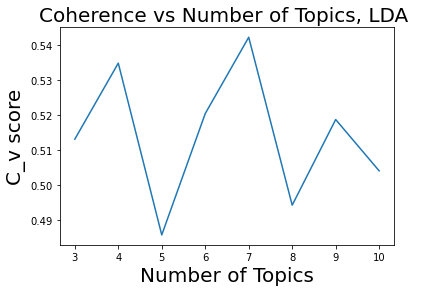

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.lineplot(x=range(3,11),y=cohereldalist,ax=ax)
ax.set_xlabel('Number of Topics',fontsize=20)
ax.set_ylabel('C_v score',fontsize=20)
ax.set_title('Coherence vs Number of Topics, LDA ',fontsize=20)
fig.savefig('./Figures/LDA/C_v_vs_topics.png',bbox_inches='tight')

#The coherence is highest when there are 5 clusters (0.51)

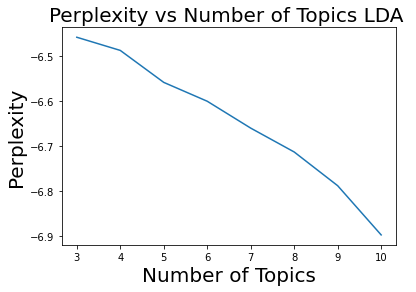

In [14]:
perplexitylist = []
for i in range(len(ldamodlist)):
    perplexitylist.append(ldamodlist[i].log_perplexity(corpus))

fig, ax = plt.subplots()
sns.lineplot(x=range(3,11),y=perplexitylist,ax=ax)
ax.set_xlabel('Number of Topics',fontsize=20)
ax.set_ylabel('Perplexity',fontsize=20)
ax.set_title('Perplexity vs Number of Topics LDA ',fontsize=20)
fig.savefig('./Figures/LDA/logperplexity_vs_topics.png',bbox_inches='tight')

